In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets, tree, linear_model
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import operator

#read in datasets
energy = pd.read_csv('../../data/energy_dataset.csv')
weather = pd.read_csv('../../data/weather_features.csv')

data_prediction = energy['price day ahead'] #for later comparison
load_prediction = energy['total load forecast']

energy = energy.drop(['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 
    'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 
    'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 
    'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 
    'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
    'total load forecast', 'price day ahead'], axis = 1)

weather = weather.drop(['temp_min', 'temp_max', 'weather_description', 'weather_icon', 'weather_id', 'weather_main'], axis = 1)


In [99]:
from scipy import interpolate
pop = np.array([46.41, 46.45, 46.53, 46.73, 47.10])
year = np.array([2015.0, 2016.0, 2017.0, 2018.0, 2019.0]) + 1/12
pop_est = interpolate.interp1d(year, pop, fill_value='extrapolate')
total_load = np.zeros(35064)
price_actual = np.zeros(35064)
wind_onshore = np.zeros(35064)
for i in range(108, len(energy)):
    date = (energy['time'][10000]).split(' ')[0]
    time = float((date.split('-'))[0]) + float((date.split('-'))[1])/12
    total_load[i]  = energy['total load actual'].iloc[i] * pop_est(time)/pop[0]
    price_actual[i] = energy['price actual'].iloc[i] * pop_est(time)/pop[0]
    wind_onshore[i] = energy['generation wind onshore'].iloc[i] * pop_est(time)/pop[0]

energy['total load actual'] = total_load
energy['price actual'] = price_actual
energy['generation wind onshore'] = wind_onshore


Val_weather = weather[weather.city_name == 'Valencia'].copy().reset_index(drop = True)
Sev_weather = weather[weather.city_name ==  'Seville'].copy().reset_index(drop = True)
Mad_weather = weather[weather.city_name ==  'Madrid'].copy().reset_index(drop = True)
Bil_weather = weather[weather.city_name ==  'Bilbao'].copy().reset_index(drop = True)
Bar_weather = weather[weather.city_name ==  ' Barcelona'].copy().reset_index(drop = True)

for i in range(len(energy)):
    if Val_weather.iloc[i]['dt_iso'] != energy.iloc[i]['time']:
        Val_weather.drop(i, axis = 0, inplace = True)
    if Sev_weather.iloc[i]['dt_iso'] != energy.iloc[i]['time']:
        Sev_weather.drop(i, axis = 0, inplace = True)
    if Mad_weather.iloc[i]['dt_iso'] != energy.iloc[i]['time']:
        Mad_weather.drop(i, axis = 0, inplace = True)
    if Bil_weather.iloc[i]['dt_iso'] != energy.iloc[i]['time']:
        Bil_weather.drop(i, axis = 0, inplace = True)
    if Bar_weather.iloc[i]['dt_iso'] != energy.iloc[i]['time']:
        Bar_weather.drop(i, axis = 0, inplace = True)


Valencia = pd.merge(energy, Val_weather, left_on="time", right_on="dt_iso")
Seville = pd.merge(energy, Sev_weather, left_on="time", right_on="dt_iso")
Madrid = pd.merge(energy, Mad_weather, left_on="time", right_on="dt_iso")
Bilbao = pd.merge(energy, Bil_weather, left_on="time", right_on="dt_iso")
Barcelona = pd.merge(energy, Bar_weather, left_on="time", right_on="dt_iso")

average = (pd.concat([Valencia, Seville, Madrid, Bilbao, Barcelona])).groupby(level = 0).mean()


In [100]:
totalPop2017= 788000 + 3183000 + 345000 + 1621000 + 689000
#Valencia, Madrid, Bilbao, Barcelona, Seville
pops2017 = np.array([788000, 3183000, 345000, 1621000, 689000]) / totalPop2017

weighted = average.copy()

for keys in weighted:
    weighted[keys] = Valencia[keys] * pops2017[0] + Madrid[keys] * pops2017[1] + Bilbao[keys] * pops2017[2] + Barcelona[keys] * pops2017[3] + Seville[keys] * pops2017[4]

#convert time to unix so its usable...
time = []
for i in energy['time']:
    date = pd.to_datetime(i[:19])
    time.append(int(date.value/(10 ** 9)))

weighted['time'] = time

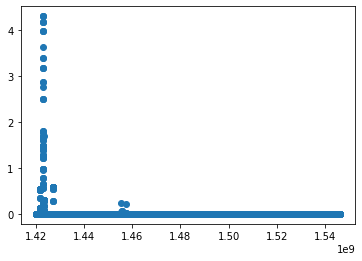

In [50]:
plt.plot(time, average['snow_3h'], 'o')

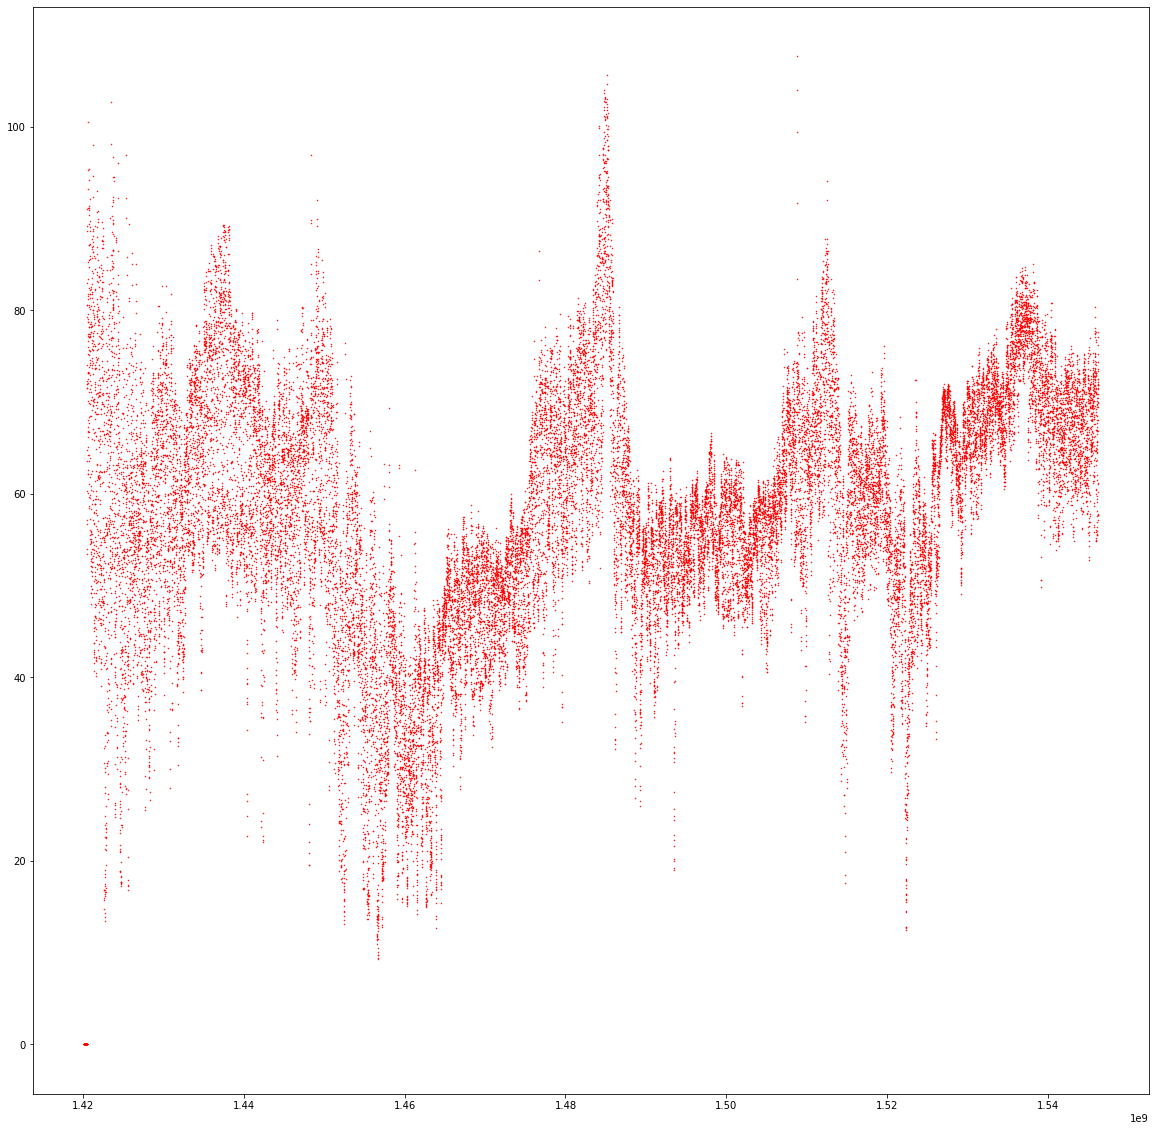

In [76]:
plt.figure(figsize = (20,20))
plt.plot(time, weighted['price actual'], 'ro', markersize = 0.5)
plt.show()

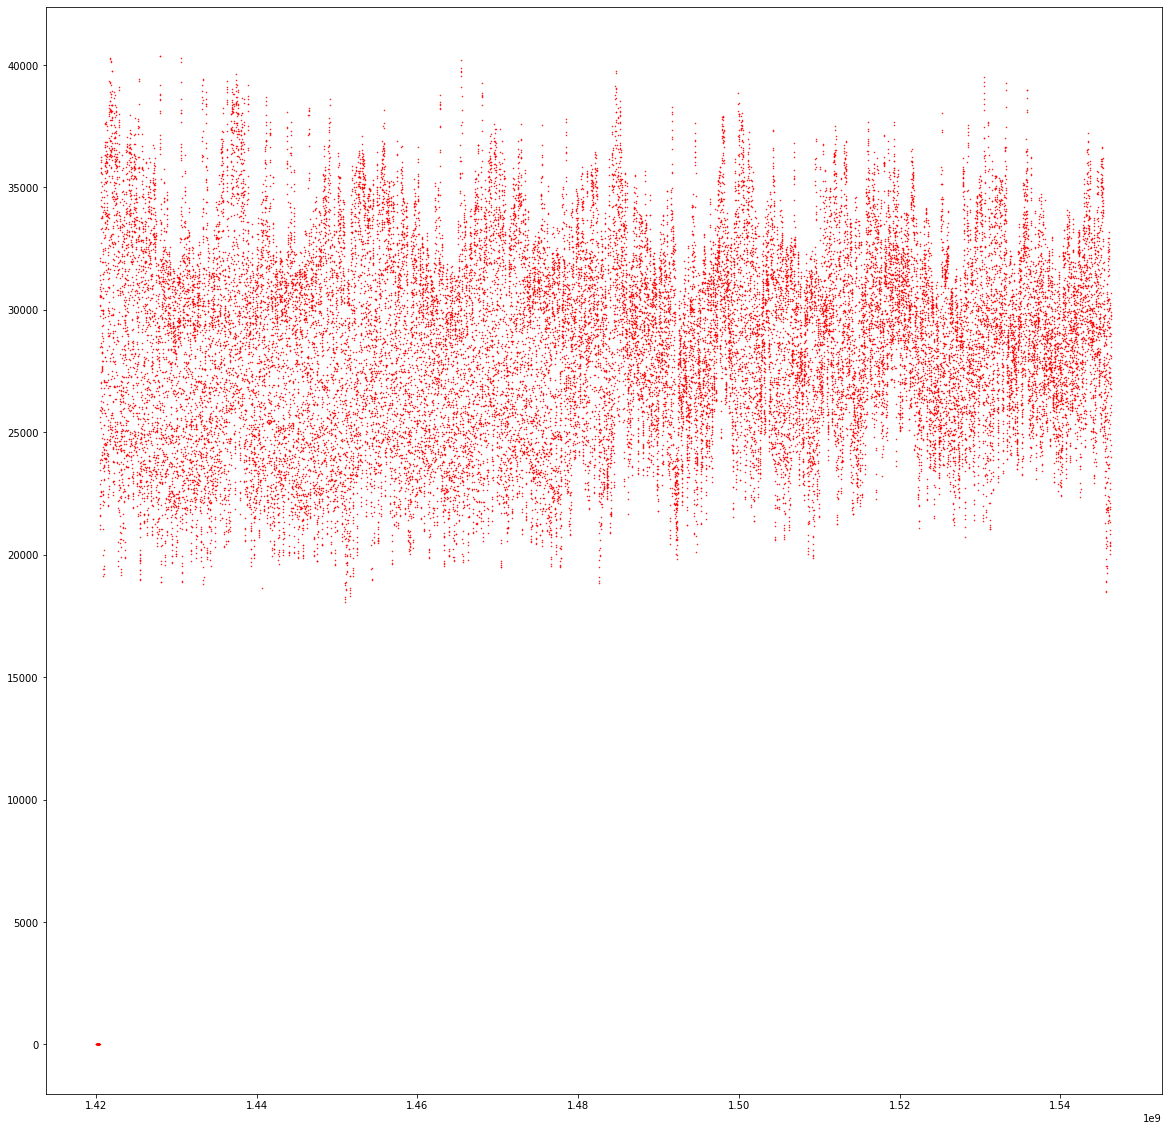

In [77]:
plt.figure(figsize = (20,20))
plt.plot(time, weighted['total load actual'], 'ro', markersize = 0.5)
plt.show()

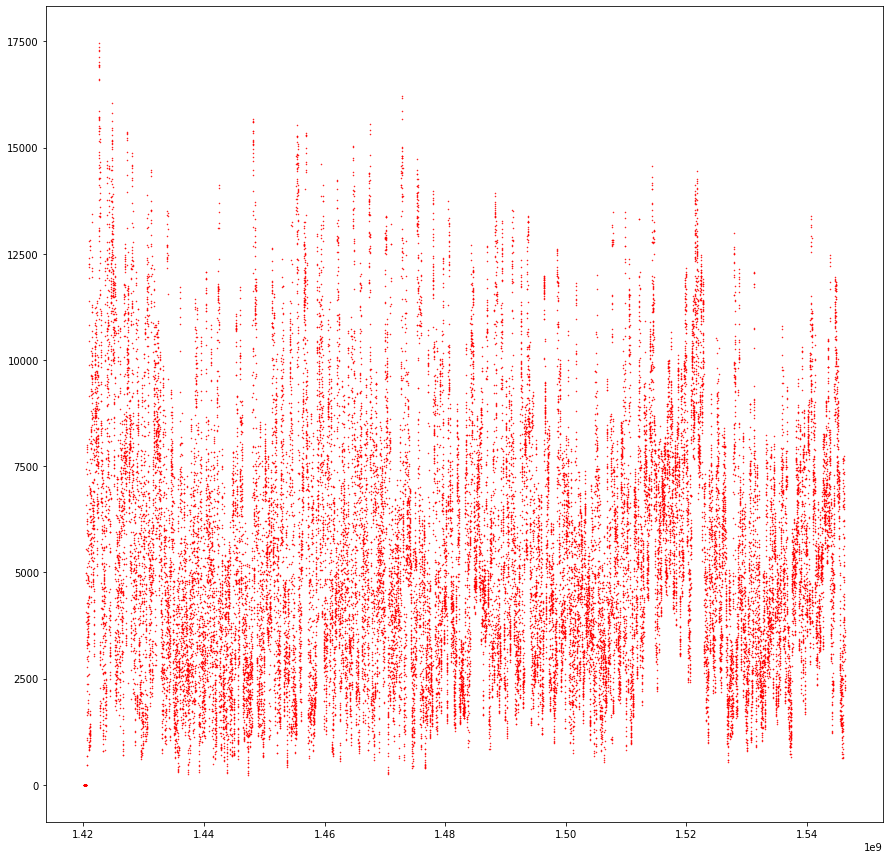

In [78]:
plt.figure(figsize = (15, 15))
plt.plot(time, weighted['generation wind onshore'], 'ro', markersize = 0.5)
plt.show()

In [128]:
loadWeighted = weighted[(weighted['total load actual'].notna()) & (weighted['total load actual'] > 5000)].copy()
windWeighted = weighted[(weighted['generation wind onshore'].notna()) & (weighted['generation wind onshore'] > 100)].copy()
priceWeighted = weighted[(weighted['price actual'].notna()) & (weighted['price actual'] > 5)].copy()


temp vs total load


/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


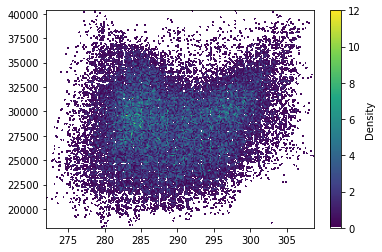

temp vs price


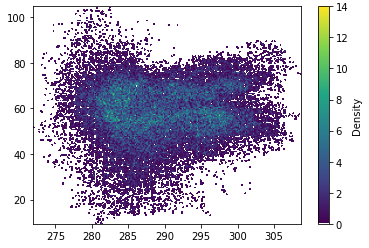

temp vs wind generation


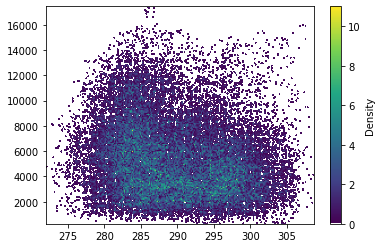

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap

white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Density')

print('temp vs total load')
fig = plt.figure()
scatter_density(fig, loadav['temp'], loadav['total load actual'])
plt.show()

print('temp vs price')
fig = plt.figure()
scatter_density(fig, priceav['temp'], priceav['price actual'])
plt.show()

print('temp vs wind generation')
fig = plt.figure()
scatter_density(fig, windav['temp'], windav['generation wind onshore'])
plt.show()

## Weighted

temp vs total load


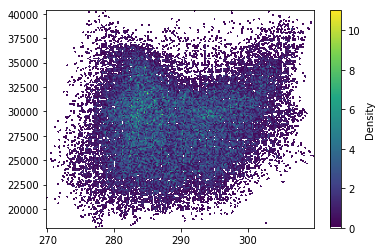

temp vs price


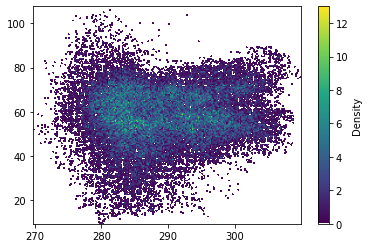

temp vs wind generation


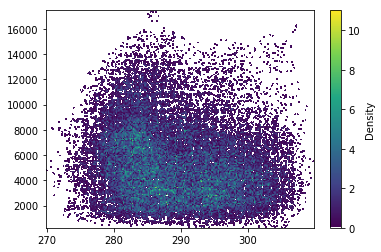

In [66]:
print('temp vs total load')
fig = plt.figure()
scatter_density(fig, loadWeighted['temp'], loadWeighted['total load actual'])
plt.show()


print('temp vs price')
fig = plt.figure()
scatter_density(fig, priceWeighted['temp'], priceWeighted['price actual'])
plt.show()

print('temp vs wind generation')
fig = plt.figure()
scatter_density(fig, windWeighted['temp'], windWeighted['generation wind onshore'])
plt.show()

## Polynomial Regressions <br>

In [67]:
def poly(x, y, degree):
    p = PolynomialFeatures(degree = degree)

    #get testing and training sets
    x_test, x_train, y_test, y_train = train_test_split(x, y, test_size = 0.2)

    #transform testing and training dataset to p sized array
    x_poly_test = p.fit_transform(x_test.values.reshape(-1, 1))
    x_poly_train = p.fit_transform(x_train.values.reshape(-1, 1))

    #create and fit model to dataset
    model = linear_model.LinearRegression()
    model.fit(x_poly_train, y_train)

    #predict models
    y_train_pred = model.predict(x_poly_train)
    y_test_pred = model.predict(x_poly_test)

    #MSEs
    print('Training Mean Squared Error ', mean_squared_error(y_train, y_train_pred))
    print('Testing Mean Squared Error ', mean_squared_error(y_test, y_test_pred))
    print('Training Root Mean Squared Error ', np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print('Testing Root Mean Squared Error ', np.sqrt(mean_squared_error(y_test, y_test_pred)))

    #plotting training data versus predicted data
    fig = plt.figure()
    scatter_density(fig, x, y)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x_train, y_train_pred), key = sort_axis)
    x_poly_train, y_train_pred = zip(*sorted_zip)
    plt.plot(x_poly_train, y_train_pred, 'r')
    plt.show()

    return model, x_train, x_test, y_train, y_test

## Polynomial Regression - Temp vs Price

Training Mean Squared Error  166.345431954274
Testing Mean Squared Error  176.18601161672623
Training Root Mean Squared Error  12.89749711976219
Testing Root Mean Squared Error  13.273507886641204


/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


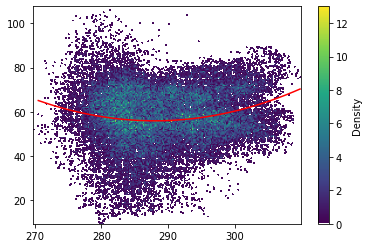

In [68]:
temp_price_d2 = poly(priceWeighted['temp'], priceWeighted['price actual'], 2)

Training Mean Squared Error  172.9820219823685
Testing Mean Squared Error  174.06964489362642
Training Root Mean Squared Error  13.15226299852495
Testing Root Mean Squared Error  13.193545577047377


/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


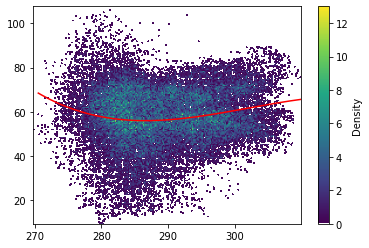

In [26]:
temp_price_d2 = poly(priceWeighted['temp'], priceWeighted['price actual'], 3)

Training Mean Squared Error  173.88685984664366
Testing Mean Squared Error  173.4534943787496
Training Root Mean Squared Error  13.186616694461232
Testing Root Mean Squared Error  13.17017442476559


/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


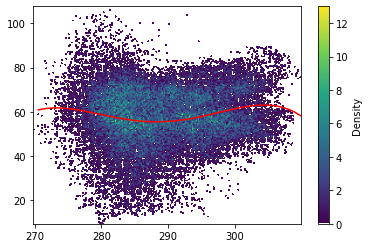

In [27]:
temp_price_d2 = poly(priceWeighted['temp'], priceWeighted['price actual'], 4)

## Polynomial Regression - Temp vs Wind

Training Mean Squared Error  8418713.127637979
Testing Mean Squared Error  8410451.126067832
Training Root Mean Squared Error  2901.501874484657
Testing Root Mean Squared Error  2900.0777793134844


/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


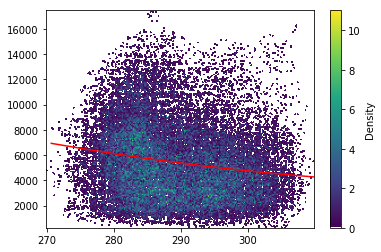

In [28]:
temp_wind = pd.DataFrame({'wind': windWeighted['generation wind onshore'], 'temp': windWeighted['temp']}).dropna()
temp_wind_d2 = poly(temp_wind['temp'], temp_wind['wind'], 2)

Training Mean Squared Error  8597503.413213812
Testing Mean Squared Error  8282070.811539048
Training Root Mean Squared Error  2932.149964311821
Testing Root Mean Squared Error  2877.8587198712603


/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


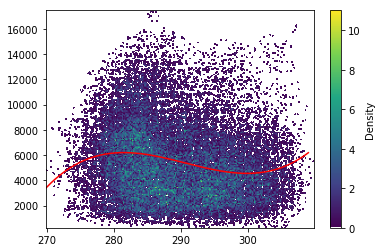

In [29]:
temp_wind_d3 = poly(temp_wind['temp'], temp_wind['wind'], 3)

## Polynomial Regression - Temp vs Load

Training Mean Squared Error  14165564.521571904
Testing Mean Squared Error  14580146.889605
Training Root Mean Squared Error  3763.7168492823557
Testing Root Mean Squared Error  3818.395852921093


/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


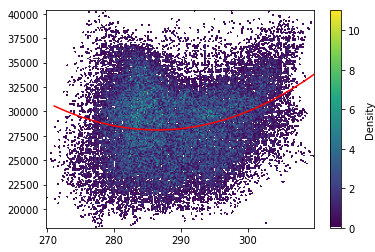

In [32]:
temp_load = pd.DataFrame({'load': loadWeighted['total load actual'], 'temp': loadWeighted['temp']}).dropna()
temp_load_d2 = poly(temp_load['temp'], temp_load['load'], 2)

Training Mean Squared Error  13948110.726541322
Testing Mean Squared Error  14196412.015698487
Training Root Mean Squared Error  3734.7169540061964
Testing Root Mean Squared Error  3767.8126301208886


/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


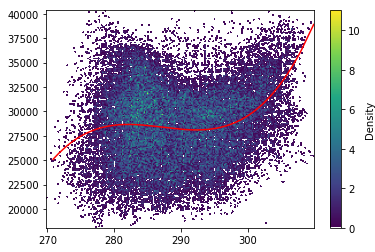

In [33]:
temp_load_d3 = poly(temp_load['temp'], temp_load['load'], 3)

Training Mean Squared Error  13834104.988059059
Testing Mean Squared Error  14106481.33328029
Training Root Mean Squared Error  3719.422668648867
Testing Root Mean Squared Error  3755.8595997827565


/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


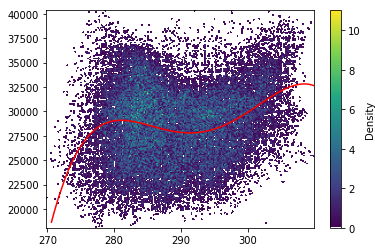

In [34]:
temp_load_d4 = poly(temp_load['temp'], temp_load['load'], 4)

In [135]:
loadWeighted = weighted[(weighted['total load actual'].notna()) & (weighted['total load actual'] > 5000)].copy()
windWeighted = weighted[(weighted['generation wind onshore'].notna()) & (weighted['generation wind onshore'] > 100)].copy()
priceWeighted = weighted[(weighted['price actual'].notna()) & (weighted['price actual'] > 5)].copy()

loadWeighted = loadWeighted.drop(['generation wind onshore', 'price actual'], axis = 1)
windWeighted = windWeighted.drop(['price actual', 'total load actual'], axis = 1)
priceWeighted = priceWeighted.drop(['generation wind onshore', 'total load actual'], axis = 1)

## SVM

In [136]:
from sklearn.datasets import make_circles
from mpl_toolkits.mplot3d import Axes3D

load = loadWeighted[['total load actual']]
wind = windWeighted[['generation wind onshore']]
price = priceWeighted[['price actual']]

loadWeighted = loadWeighted.drop(['total load actual'], axis = 1)
windWeighted = windWeighted.drop(['generation wind onshore'], axis = 1)
priceWeighted = priceWeighted.drop(['price actual'], axis = 1)

In [126]:
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

def SVM(x, y):

    #pre processing data
    sx = MinMaxScaler()
    sy = MinMaxScaler()
    x = sx.fit_transform(x)
    y = sy.fit_transform(y)

    #split into training and testing data sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    model = svm.SVR()
    model.fit(x_train, np.ravel(y_train))
    y_pred = model.predict(x_test)
    
    print("Score: ", model.score(x_test, y_test))
    print('Testing Mean Squared Error ', mean_squared_error(y_test, y_pred))
    print('Testing Root Mean Squared Error ', np.sqrt(mean_squared_error(y_test, y_pred)))



In [137]:
SVM(loadWeighted, load)

Score:  0.18322065612863414
Testing Mean Squared Error  0.025105154970120124
Testing Root Mean Squared Error  0.15844606328375635


In [138]:
SVM(priceWeighted, price)

Score:  0.43136775463077714
Testing Mean Squared Error  0.010293404374361773
Testing Root Mean Squared Error  0.10145641613206025


In [139]:
SVM(windWeighted, wind)

Score:  0.2153108527224672
Testing Mean Squared Error  0.02283327542452734
Testing Root Mean Squared Error  0.15110683447325385


## Legacy

In [45]:
#split energy columns into separate datasets for easier viewing
def split(city, col_name, dataset):
    for i in energy.columns:
        if i != col_name:
            dataset = dataset.drop(i, axis = 1)
    get_plots(city, col_name, dataset)
    return dataset

def heatmap(city, col_name, dataset):
    fig, ax = plt.subplots(figsize = (20, 20))
    sns.heatmap(dataset.corr(), annot = True, vmin = -1, vmax = 1, ax = ax)
    fig.savefig('/home/claire/Documents/ECS171/%s/%s_%s_heatmap.png' %(city, city, col_name.replace('/', ' ')))
    plt.show()

def pairplot(city, col_name, dataset):
    sns.pairplot(dataset, y_vars = [col_name])#, hue = 'weather_id')
    plt.savefig('/home/claire/Documents/ECS171/%s/%s_%s_pairplot.png' %(city, city, col_name.replace('/', ' ')))
    
def get_plots(city, col_name, dataset):
    heatmap(city, col_name, dataset)
    pairplot(city, col_name, dataset)

def analyze(city, dataset):
    biomass = split(city, 'generation biomass', dataset)
    lignite = split(city, 'generation fossil brown coal/lignite', dataset)
    coal = split(city, 'generation fossil hard coal', dataset)
    oil = split(city, 'generation fossil oil', dataset)
    shale_oil = split(city, 'generation fossil oil shale', dataset)
    peat = split(city, 'generation fossil peat', dataset)
    geothermal = split(city, 'generation geothermal', dataset)
    hydropump_storage_tot = split(city, 'generation hydro pumped storage aggregated', dataset)
    hydropump_storage_cons = split(city, 'generation hydro pumped storage consumption', dataset)
    hydro_river = split(city, 'generation hydro run-of-river and poundage', dataset)
    water_rsv = split(city, 'generation hydro water reservoir', dataset)
    marine = split(city, 'generation marine', dataset)
    nuclear = split(city, 'generation nuclear', dataset)
    other = split(city, 'generation other', dataset)
    other_renew = split(city, 'generation other renewable', dataset)
    solar = split(city, 'generation solar', dataset)
    waste = split(city, 'generation waste', dataset)
    offshore_wind = split(city, 'generation wind offshore', dataset)
    onshore_wind = split(city, 'generation wind onshore', dataset)
    forecasted_solar = split(city, 'forecast solar day ahead', dataset)
    forecasted_offshore_wind = split(city, 'forecast wind offshore eday ahead', dataset)
    forecasted_onshore_wind = split(city, 'forecast wind onshore day ahead', dataset)
    forecasted_load = split(city, 'total load forecast', dataset)
    total_load = split(city, 'total load actual', dataset)
    predicted_price = split(city, 'price day ahead', dataset)
    price = split(city, 'price actual', dataset)

In [ ]:
#analyze('Valencia', Valencia)
analyze('Seville', Seville)
analyze('Madrid', Madrid)
analyze('Bilbao', Bilbao)
analyze('Barcelona', Barcelona)